<a href="https://colab.research.google.com/github/meghana1827/Sentimental-Analysis-For-Stock-Prediction/blob/main/22027065(Stock_Price_Prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing Required Packages

In [405]:
! pip install -q yfinance pandas numpy matplotlib scikit-learn==1.5.2 xgboost tensorflow==2.18 newsapi-python textblob seaborn plotly requests

#Importing Required Libraries

In [406]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU , Dense , Dropout , Input
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

#Using Historic Data Alone

In [407]:
# Parameters for stock price prediction and model configuration
parameters = {
    # Stock and Date Information
    'ticker': 'AAPL',  # Ticker symbol for the stock to be predicted (e.g., AAPL, TSLA)
    'start_date': '2022-01-03',  # Start date for the historical data (YYYY-MM-DD)
    'end_date': '2024-01-03',    # End date for the historical data (YYYY-MM-DD)

    # Data Preparation Settings
    'look_back': 60,  # Number of days to look back for predicting future prices
    'prediction_days': 10,  # Number of days to predict into the future

    # Model Training Settings
    'epochs': 10,  # Number of epochs to train the model
    'batch_size': 32,  # Batch size for model training

    # Test/Training Split
    'test_size': 0.2,  # Fraction of the data to use for testing (0.2 = 20%)

    # Data Scaling
    'scaler': MinMaxScaler()  # Scaling method to normalize data (MinMaxScaler is used here)
}

#Collecting Historic Data

In [408]:
# Download stock data using yfinance
df = yf.download(
    parameters['ticker'],
    start=parameters['start_date'],
    end=parameters['end_date']
)

# Use features for prediction
features = ['Close', 'Open', 'High', 'Low', 'Volume']
data = df[features]

# Print data shape and the first 10 rows for preview
print(f'\nData shape: {data.shape}')
print("\nFirst 10 rows of the data:\n")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(data.head(10))  # Display the first 10 rows

# Creating a table to display feature descriptions in a professional format
feature_descriptions = {
    "Feature": ["Close", "Open", "High", "Low", "Volume"],
}

# Convert the dictionary to a DataFrame for better readability
feature_table = pd.DataFrame(feature_descriptions)


[*********************100%***********************]  1 of 1 completed


Data shape: (502, 5)

First 10 rows of the data:

Price            Close        Open        High         Low     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2022-01-03  182.009995  177.830002  182.880005  177.710007  104487900
2022-01-04  179.699997  182.630005  182.940002  179.119995   99310400
2022-01-05  174.919998  179.610001  180.169998  174.639999   94537600
2022-01-06  172.000000  172.699997  175.300003  171.639999   96904000
2022-01-07  172.169998  172.889999  174.139999  171.029999   86709100
2022-01-10  172.190002  169.080002  172.500000  168.169998  106765600
2022-01-11  175.080002  172.320007  175.179993  170.820007   76138300
2022-01-12  175.529999  176.119995  177.179993  174.820007   74805200
2022-01-13  172.190002  175.779999  176.619995  171.789993   84505800
2022-01-14  173.070007  171.339996  173.779999  171.089996   80440800


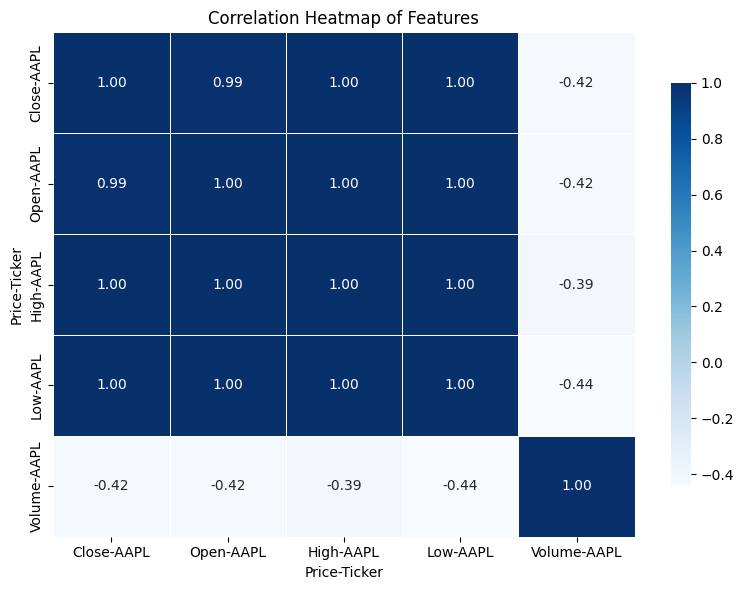

In [409]:

# Assuming 'data' is your DataFrame containing features
corr_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with a light blue color palette
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})

# Add title and labels
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()


#Data PreProcessing

##Clean and Normalize Historic Data

In [410]:
# Scaling the data using the specified scaler (MinMaxScaler in this case)
scaled_data = parameters['scaler'].fit_transform(data)

# Print the scaled data to observe the changes after scaling
print(f'Scaled Data:\n{scaled_data}')


Scaled Data:
[[0.77972356 0.71962225 0.76701474 0.73513672 0.50733348]
 [0.74811872 0.7862797  0.76784978 0.75449671 0.47467893]
 [0.68271992 0.74434102 0.72929718 0.69298366 0.44457682]
 ...
 [0.93802164 0.94611853 0.93096741 0.94741176 0.06308021]
 [0.92365575 0.94278558 0.92734862 0.92763965 0.11718743]
 [0.82938842 0.8490486  0.84439815 0.81999176 0.36858427]]


#Feature Engineering

In [411]:
# Prepare sequences for input (X) and target (y)
X, y = [], []  # Initialize empty lists for features and labels

# Loop to create sequences from the scaled data
for index in range(parameters['look_back'], len(scaled_data)):
    X.append(scaled_data[index-parameters['look_back']:index])  # Append input sequence
    y.append(scaled_data[index, 0])  # Append target value (Close price)

# Convert lists to NumPy arrays for model input
X, y = np.array(X), np.array(y)  # Convert to arrays


#Data Splitting

In [412]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [413]:
# Reshape the training data for GRU (3D input for GRU)
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Flatten the training data for Random Forest and XGBoost (2D input for tree-based models)
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)


In [414]:
# Print the shape of the training and testing datasets
print(f'\nX_train Shape : {X_train.shape}')
print(f'X_test Shape : {X_test.shape}')

# Print the shape of the training and testing labels
print(f'\nY_train Shape : {y_train.shape}')
print(f'Y_test Shape : {y_test.shape}')

# Print the shape of the reshaped GRU training and testing datasets
print(f'\nX_train_gru Shape : {X_train_gru.shape}')
print(f'X_test_gru Shape : {X_test_gru.shape}')

# Print the shape of the reshaped Random Forest and XGBoost training and testing datasets
print(f'\nX_train_rf Shape : {X_train_rf.shape}')
print(f'X_test_rf Shape : {X_test_rf.shape}')

# Print the shape of the labels again (confirming both training and testing labels)
print(f'\nY_train Shape : {y_train.shape}')
print(f'Y_test Shape : {y_test.shape}')



X_train Shape : (353, 60, 5)
X_test Shape : (89, 60, 5)

Y_train Shape : (353,)
Y_test Shape : (89,)

X_train_gru Shape : (353, 60, 5)
X_test_gru Shape : (89, 60, 5)

X_train_rf Shape : (353, 300)
X_test_rf Shape : (89, 300)

Y_train Shape : (353,)
Y_test Shape : (89,)


#Training Models

##GRU(Grated Recurrent Unit) Model

In [415]:
# Define the GRU model architecture
gru_model = Sequential([
    # First GRU layer with 100 units, returns sequences for the next GRU layer
    GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),

    # Dropout layer to prevent overfitting
    Dropout(0.2),

    # Second GRU layer with 50 units
    GRU(50),

    # Another Dropout layer to reduce overfitting
    Dropout(0.2),

    # Dense layer with 25 units and ReLU activation function
    Dense(25, activation='relu'),

    # Output layer with 1 unit (for regression)
    Dense(1)
])

# Compile the model with Adam optimizer and Mean Squared Error loss function
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model with training data
history = gru_model.fit(
    X_train_gru, y_train,  # Input data (features) and labels (target)
    epochs=100,  # Number of training epochs
    batch_size=32,  # Number of samples per batch
    validation_split=0.2,  # 20% of the data will be used for validation
    # verbose=0  # Optionally, you can set this to 0 to silence output
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2306 - val_loss: 0.0368
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0373 - val_loss: 0.0123
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0169 - val_loss: 0.0063
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082 - val_loss: 0.0047
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - val_loss: 0.0049
E

##XGBoost Regressor

In [416]:
# Define the XGBoost regression model
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Step size shrinking to prevent overfitting
    random_state=42  # Random seed for reproducibility
)

# Train the XGBoost model with the training data
xgb_model.fit(X_train_rf, y_train)  # Fit the model on the reshaped training data and target labels


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

##Random Forest Model

In [417]:
# Define the Random Forest regression model
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    random_state=42,    # Random seed for reproducibility
    max_depth=10        # Maximum depth of each tree to control overfitting
)

# Train the Random Forest model with the reshaped training data
rf_model.fit(X_train_rf, y_train)  # Fit the model on the reshaped training data and target labels


RandomForestRegressor(max_depth=10, random_state=42)

#Evaluate Models

In [418]:
def _calculate_directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy (percentage of times
    the model predicts the correct price movement direction)

    :param y_true: True values
    :param y_pred: Predicted values
    :return: Directional accuracy percentage
    """
    # Ensure that both inputs have the same length
    if len(y_true) != len(y_pred):
        raise ValueError("True values and predicted values must have the same length")

    # Calculate price changes
    true_changes = np.diff(y_true)
    pred_changes = np.diff(y_pred)

    # Compare directions
    correct_directions = np.sum(np.sign(true_changes) == np.sign(pred_changes))
    total_comparisons = len(true_changes)

    # Prevent division by zero if there are no comparisons
    if total_comparisons == 0:
        return 0.0

    # Calculate directional accuracy
    accuracy = (correct_directions / total_comparisons) * 100

    return accuracy


In [419]:
def _calculate_metrics(y_true, y_pred):
    """
    Calculate a set of performance metrics to evaluate the model's predictions.

    This function computes the following metrics:
    - R² Score: A measure of how well the model's predictions match the true values.
    - RMSE (Root Mean Squared Error): A measure of the differences between predicted and true values.
    - MAE (Mean Absolute Error): The average absolute differences between predicted and true values.
    - MAPE (Mean Absolute Percentage Error): The average percentage error between predictions and true values.
    - Directional Accuracy: The percentage of time the model predicts the correct price direction (up or down).

    :param y_true: Array or list of true values (ground truth).
    :param y_pred: Array or list of predicted values from the model.
    :return: A dictionary containing all computed metrics.
    """

    # Calculate R² Score (coefficient of determination)
    r2 = r2_score(y_true, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    # Calculate directional accuracy (percentage of correct price movement direction)
    accuracy = _calculate_directional_accuracy(y_true, y_pred)

    # Return the metrics in a dictionary
    return {
        'R2 Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Accuracy': accuracy
    }


In [420]:
def _print_accuracy_report(models_metrics):
    """
    Print a comprehensive accuracy report for all models.

    This function iterates through the dictionary of model metrics and prints each model's performance,
    including various evaluation metrics like R2, RMSE, MAE, MAPE, and Directional Accuracy.

    :param models_metrics: A dictionary where the key is the model name (str) and the value is a dictionary
                            containing performance metrics for that model.
    """
    # Print the report header
    print("\n" + "="*50)
    print(f"STOCK PRICE PREDICTION ACCURACY REPORT FOR {parameters['ticker']}")
    print("="*50)

    # Iterate through each model in the metrics dictionary
    for model_name, metrics in models_metrics.items():
        print(f"\n{model_name} Model Performance:")
        print("-"*30)

        # Print each metric and its corresponding value for the model
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")  # Format the value to 4 decimal places


In [421]:
# Predict values using the trained models
gru_pred = gru_model.predict(X_test_gru).flatten()  # Predict using GRU model
rf_pred = rf_model.predict(X_test_rf)  # Predict using Random Forest model
xgb_pred = xgb_model.predict(X_test_rf)  # Predict using XGBoost model

# Inverse transform predictions and actual values back to the original scale
# We use np.column_stack to align the predicted values with zeros for other features
gru_pred_inv = parameters['scaler'].inverse_transform(np.column_stack([gru_pred, np.zeros((len(gru_pred), data.shape[1]-1))]))[:, 0]
rf_pred_inv = parameters['scaler'].inverse_transform(np.column_stack([rf_pred, np.zeros((len(rf_pred), data.shape[1]-1))]))[:, 0]
xgb_pred_inv = parameters['scaler'].inverse_transform(np.column_stack([xgb_pred, np.zeros((len(xgb_pred), data.shape[1]-1))]))[:, 0]
y_test_inv = parameters['scaler'].inverse_transform(np.column_stack([y_test, np.zeros((len(y_test), data.shape[1]-1))]))[:, 0]

# Calculate performance metrics for each model
models_metrics = {
    'GRU': _calculate_metrics(y_test_inv, gru_pred_inv),  # GRU model metrics
    'Random Forest': _calculate_metrics(y_test_inv, rf_pred_inv),  # Random Forest model metrics
    'XGBoost': _calculate_metrics(y_test_inv, xgb_pred_inv)  # XGBoost model metrics
}

# Print the accuracy report for all models
_print_accuracy_report(models_metrics)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

STOCK PRICE PREDICTION ACCURACY REPORT FOR AAPL

GRU Model Performance:
------------------------------
R2 Score: 0.9723
RMSE: 3.1564
MAE: 2.4147
MAPE: 1.5050
Accuracy: 95.4545

Random Forest Model Performance:
------------------------------
R2 Score: 0.9754
RMSE: 2.9774
MAE: 2.2911
MAPE: 1.4505
Accuracy: 95.4545

XGBoost Model Performance:
------------------------------
R2 Score: 0.9706
RMSE: 3.2531
MAE: 2.5236
MAPE: 1.6025
Accuracy: 95.4545


In [422]:
last_sequence = X[-1:]
forecasts = []

for _ in range(10) :

    # Get predictions from each model
    gru_forecast = gru_model.predict(last_sequence)  # Shape: (1, prediction_days)
    xgb_forecast = xgb_model.predict(last_sequence.reshape(1, -1))  # Shape: (1, prediction_days)
    rf_forecast = rf_model.predict(last_sequence.reshape(1, -1))    # Shape: (1, prediction_days)

    ensemble_forecast = (gru_forecast + xgb_forecast + rf_forecast) / 3

    forecast = ensemble_forecast[0][0]

    forecasts.append(forecast)
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1] = forecast

forecasts = parameters['scaler'].inverse_transform(
    np.hstack(
        (
            np.array(forecasts).reshape(-1 , 1),
            np.zeros((10 , 4))
        )
    )
).T[0].tolist()

for index , value in enumerate(forecasts) : print(f'Day {index + 1} : ${value}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Day 1 : $188.68369651055536
Day 2 : $186.93358537199148
Day 3 : $185.71044975355136
Day 4 : $185.0816882173678
Day 5 : $184.6837366631355
Day 6 : $183.86754982722633
Day 7 : $183.3231781276269
Day 8 : $182.62044101179345
Day 9 : $180.43249626680776
Day 10 : $178.69883023451234


#Visualizations

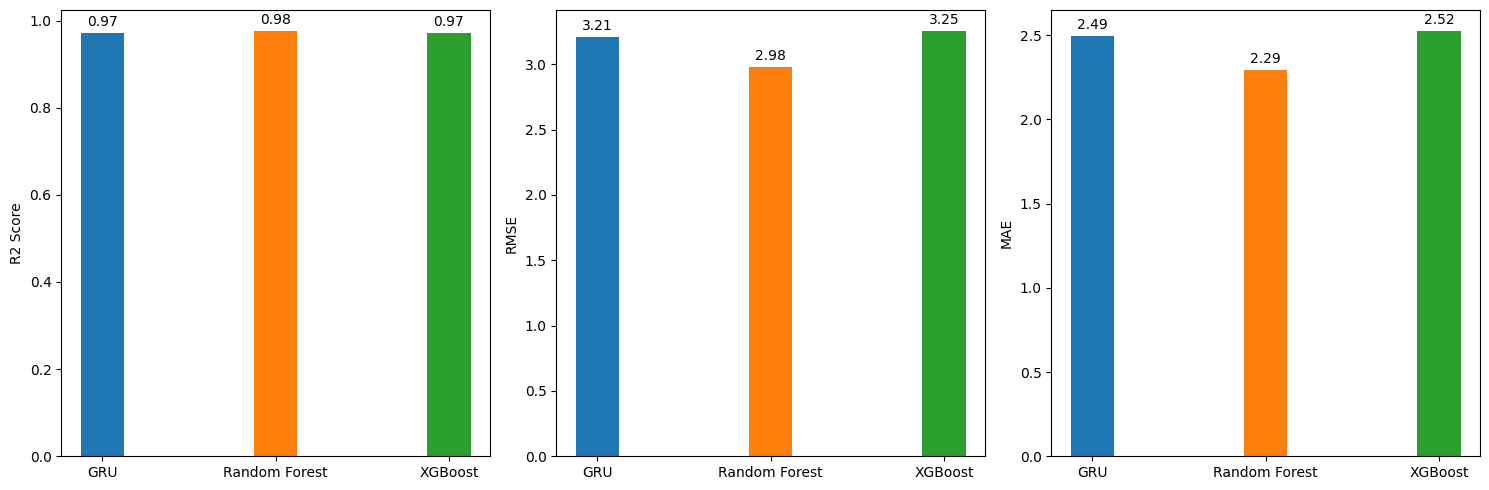

Text(0, 0.5, 'MAPE')

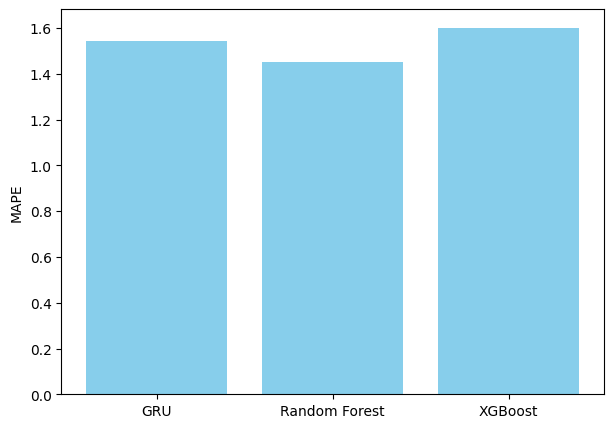

In [383]:
# Extract model names and metric names
models = list(models_metrics.keys())
metrics = list(models_metrics['GRU'].keys())

# --- R2 Score, RMSE, and MAE ---
metric_to_plot = ['R2 Score', 'RMSE', 'MAE']  # Metrics to plot for comparison

# Set position for the bars
x = np.arange(len(models))
width = 0.25  # Width of the bars

# Specify custom colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create subplots for each metric
fig, axs = plt.subplots(1, len(metric_to_plot), figsize=(15, 5), sharey=False)

# Loop through each metric and plot it
for idx, metric in enumerate(metric_to_plot):
    values = [models_metrics[model][metric] for model in models]  # Get values for the current metric

    # Create the bar chart for the metric
    rects = axs[idx].bar(x, values, width, label=metric, color=colors[:len(models)])  # Limit colors to the number of models

    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(models)
    axs[idx].set_ylabel(metric)  # Set ylabel for the metric

    # Annotate the bars with the metric value
    for rect in rects:
        height = rect.get_height()
        axs[idx].annotate(f'{height:.2f}',  # Annotate with 2 decimal places
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom')

# Adjust layout to avoid overlap
fig.tight_layout()
plt.show()

# --- MAPE ---
metric_to_plot = 'MAPE'  # Set metric to plot for MAPE
values = [models_metrics[model][metric_to_plot] for model in models]

# Create a bar chart for MAPE
plt.figure(figsize=(7, 5))
plt.bar(models, values, label=metric_to_plot, color='skyblue')  # Sky blue color for MAPE
plt.ylabel(metric_to_plot)  # Set y


#Combined Data(Historic Data + Sentiment Data)

In [423]:
#parameters
parameters = {
    'ticker' : 'AAPL' ,
    'start_date' : '2022-01-01' ,
    'end_date' : '2024-01-01' ,
    'look_back' : 60 ,
    'prediction_days' : 10 ,
    'epochs' : 10 ,
    'batch_size' : 32 ,
    'test_size' : 0.2 ,
    'scaler' : MinMaxScaler() ,
}

#Collecting Historic Data

In [424]:
#Download Stock Data
stock = yf.Ticker(parameters['ticker'])
df = stock.history(start=parameters['start_date'])

print(f'Data Shape : {df.shape}')

Data Shape : (755, 7)


#Collecting Sentiment Data

In [425]:
def get_sentiment_scores(prices):
   """
   Fetch news sentiment scores from Alpha Vantage API for the given stock and calculate
   sentiment scores by combining the news sentiment with the price fluctuations.

   :param prices: List or array of stock prices (must be in chronological order)
   :return: List of sentiment scores adjusted based on stock price fluctuations
   """

   # Ensure prices are a numpy array and reshape it for proper handling
   prices = np.array(prices).reshape(1, -1)[0]
   print("Processing prices array of shape:", prices.shape)

   # Fetch news sentiment data from Alpha Vantage API
   url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey=SVG59GGO7G4OL537&limit=1000'
   r = requests.get(url)
   data = r.json()
   print("\nFetched sentiment data from Alpha Vantage API")

   # Initialize list to store sentiment scores
   sentiments = []

   # Loop through each news feed entry and extract sentiment scores
   print("\nExtracting sentiment scores from news feed...")
   for row in data.get('feed', []):  # Safely access the 'feed' key
       found = False  # Flag to check if the sentiment for 'AAPL' is found

       # Check the sentiment of each ticker in the feed
       ticker_sentiments = row.get('ticker_sentiment', [])
       for ticker in ticker_sentiments:
           if ticker['ticker'] == 'AAPL':  # Check for AAPL ticker sentiment
               sentiments.append(float(ticker['ticker_sentiment_score']))
               found = True
               break

       # If no sentiment was found for 'AAPL', add a default score
       if not found:
           sentiments.append(float(ticker['ticker_sentiment_score']))

   print(f"Found {len(sentiments)} sentiment scores")

   # Ensure the lengths of sentiments and prices match
   if len(sentiments) != len(prices):
       print(f"\nAdjusting sentiment scores length from {len(sentiments)} to match prices length {len(prices)}")
       if len(sentiments) > len(prices):
           sentiments = sentiments[:len(prices)]
           print("Truncated excess sentiment scores")
       else:
           avg_sentiment = sum(sentiments) / len(sentiments)
           sentiments.extend([avg_sentiment] * (len(prices) - len(sentiments)))
           print("Extended sentiment scores with average value:", avg_sentiment)

   # Convert sentiments list to a numpy array
   sentiments = np.array(sentiments)
   print("\nConverted sentiments to numpy array of shape:", sentiments.shape)

   # Calculate price fluctuations
   fluctuations = np.diff(prices, prepend=prices[0])
   print("Calculated price fluctuations")

   # Scale the fluctuations
   scaler = MinMaxScaler()
   scaled_fluctuations = scaler.fit_transform(fluctuations.reshape(-1, 1)).flatten()
   print("Scaled price fluctuations to range [0,1]")

   # Combine sentiment scores with price fluctuations
   sentiments = [(sentiment + fluctuation) / 2 for sentiment, fluctuation in zip(sentiments, scaled_fluctuations)]
   print("\nCombined sentiment scores with price fluctuations")
   print(f"Final sentiment scores shape: {np.array(sentiments).shape}")

   return sentiments

#Historic Data Features

In [426]:
def calculate_rsi(prices, period=14):
    """
    Calculate the Relative Strength Index (RSI) technical indicator.

    RSI is a momentum oscillator that measures the speed and change of price movements.
    It oscillates between 0 and 100, with values above 70 typically indicating overbought conditions
    and below 30 indicating oversold conditions.

    :param prices: A pandas Series containing historical stock prices.
    :param period: The number of periods over which the RSI is calculated (default is 14).
    :return: A pandas Series containing the RSI values.
    """
    # Calculate the daily price change (delta)
    delta = prices.diff()

    # Gain: Positive changes (set negative values to 0)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()

    # Loss: Negative changes (set positive values to 0)
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    # Relative Strength (RS) is the ratio of average gain to average loss
    rs = gain / loss

    # RSI calculation
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) technical indicator.

    MACD is a trend-following momentum indicator that shows the relationship between two
    moving averages of a security’s price. The MACD is the difference between the 12-day and
    26-day exponential moving averages (EMA) of the closing price.

    :param prices: A pandas Series containing historical stock prices.
    :param fast: The number of periods for the fast EMA (default is 12).
    :param slow: The number of periods for the slow EMA (default is 26).
    :param signal: The number of periods for the signal line (default is 9).
    :return: A pandas Series containing the MACD values.
    """
    # Calculate the fast (short-term) and slow (long-term) exponential moving averages (EMA)
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()

    # MACD is the difference between the fast and slow EMAs
    macd = exp1 - exp2

    # Signal line is the EMA of the MACD (usually 9 periods)
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    # The MACD Histogram is the difference between MACD and the signal line
    macd_histogram = macd - signal_line

    return macd_histogram


#Combining data(Historic Data + Sentiment Data)

In [427]:
# Moving Averages
df['MA7'] = df['Close'].rolling(window=7).mean()  # 7-day Moving Average
df['MA21'] = df['Close'].rolling(window=21).mean()  # 21-day Moving Average

# RSI (Relative Strength Index)
df['RSI'] = calculate_rsi(df['Close'])  # Compute the RSI using the 'Close' price

# MACD (Moving Average Convergence Divergence)
df['MACD'] = calculate_macd(df['Close'])  # Compute the MACD using the 'Close' price

# Sentiment Scores from News Data
df['Sentiment'] = get_sentiment_scores(df['Close'])  # Sentiment scores based on the stock price movements


Processing prices array of shape: (755,)

Fetched sentiment data from Alpha Vantage API

Extracting sentiment scores from news feed...
Found 675 sentiment scores

Adjusting sentiment scores length from 675 to match prices length 755
Extended sentiment scores with average value: 0.16106198814814798

Converted sentiments to numpy array of shape: (755,)
Calculated price fluctuations
Scaled price fluctuations to range [0,1]

Combined sentiment scores with price fluctuations
Final sentiment scores shape: (755,)


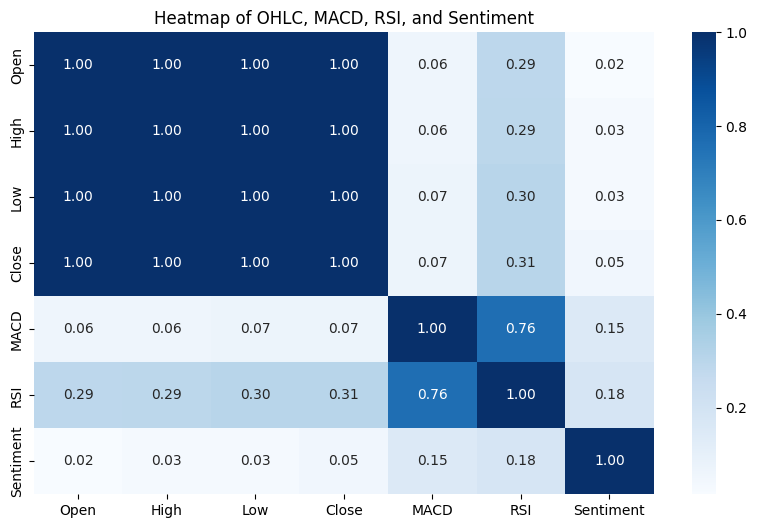

In [428]:
# Select data for heatmap
heatmap_data = df[["Open", "High", "Low", "Close", "MACD", "RSI", "Sentiment"]]

# Create a heatmap with light blue colors
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Heatmap of OHLC, MACD, RSI, and Sentiment")
plt.show()


#Feature Engineering

In [429]:
# Drop rows with missing values from the DataFrame
df = df.dropna()

# Select relevant features for model training and scale them
features = ['Close', 'Volume', 'MA7', 'MA21', 'RSI', 'MACD', 'Sentiment']
scaled_data = parameters['scaler'].fit_transform(df[features])

# Initialize empty lists to store input (X) and target (y) sequences
X, y = [], []

# Loop through data to create sequences of 'look_back' days of features and 'prediction_days' target values
for i in range(parameters['look_back'], len(scaled_data) - parameters['prediction_days']):
    X.append(scaled_data[i-parameters['look_back']:i])  # Add a sequence of past 'look_back' days
    y.append(scaled_data[i:i+parameters['prediction_days'], 0])  # Add the next 'prediction_days' target values (Close price)

# Convert the sequences to numpy arrays for model input
X, y = np.array(X), np.array(y)


#Splitting Data

In [430]:
# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]  # Split features
y_train, y_test = y[:train_size], y[train_size:]  # Split target labels

# Reshape the data for compatibility with XGBoost and Random Forest (2D array)
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Print the shapes of the training and testing sets for inspection
print(f'\nxtrain Shape : {X_train.shape}')
print(f'xtest Shape : {X_test.shape}')

print(f'\nytrain Shape : {y_train.shape}')
print(f'ytest Shape : {y_test.shape}')

print(f'\nX_train_2d Shape : {X_train_2d.shape}')
print(f'X_test_2d Shape : {X_test_2d.shape}')



xtrain Shape : (532, 60, 7)
xtest Shape : (133, 60, 7)

ytrain Shape : (532, 10)
ytest Shape : (133, 10)

X_train_2d Shape : (532, 420)
X_test_2d Shape : (133, 420)


#Training Models

##GRU Model

In [431]:
# Define the input shape for the model, using the look-back period and number of features
input_shape = (parameters['look_back'], X.shape[2])


In [432]:
# Define the GRU model architecture with dropout and dense layers
gru_model = Sequential([
    GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  # First GRU layer with 100 units
    Dropout(0.2),  # Dropout layer to prevent overfitting
    GRU(50),  # Second GRU layer with 50 units
    Dropout(0.2),  # Dropout layer for regularization
    Dense(25, activation='relu'),  # Fully connected layer with 25 neurons and ReLU activation
    Dense(parameters['prediction_days'])  # Output layer with units corresponding to prediction days
])

# Compile the model with Adam optimizer and MSE loss function
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model using training data with validation split
history = gru_model.fit(
    X_train, y_train,  # Input and target data
    epochs=100,  # Number of training epochs
    batch_size=32,  # Batch size for training
    validation_split=0.2,  # Fraction of data used for validation
    # verbose=0  # Uncomment for silent training (optional)
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0765 - val_loss: 0.0210
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0218 - val_loss: 0.0151
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - val_loss: 0.0054
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

##XGBoost Regressor

In [433]:
# Initialize XGBoost Regressor model with squared error objective function
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Train the XGBoost model using the reshaped training data (2D)
xgb_model.fit(X_train_2d, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##RF Model

In [434]:
# Initialize RandomForestRegressor with 100 estimators (trees)
rf_model = RandomForestRegressor(n_estimators=1000)

# Train the RandomForest model using the reshaped training data (2D)
rf_model.fit(X_train_2d, y_train)


RandomForestRegressor(n_estimators=1000)

##Evaluation

In [435]:
# Predict stock prices using the trained GRU model on the test data
gru_pred = gru_model.predict(X_test)

# Predict stock prices using the trained XGBoost model on the reshaped test data (2D)
xgb_pred = xgb_model.predict(X_test_2d)

# Predict stock prices using the trained Random Forest model on the reshaped test data (2D)
rf_pred = rf_model.predict(X_test_2d)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


#Ensemble Model for combining GRU, XGBoost, RandomForest

In [436]:
# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


ensemble_pred = (gru_pred + xgb_pred + rf_pred) / 3
# Calculate performance metrics for each model
results = {
    'GRU': {
        'RMSE': np.sqrt(mean_squared_error(y_test, gru_pred)),  # Root Mean Squared Error for GRU
        'MAE': mean_absolute_error(y_test, gru_pred),  # Mean Absolute Error for GRU
        'R2': r2_score(y_test, gru_pred),  # R2 Score for GRU
        'MAPE': mean_absolute_percentage_error(y_test, gru_pred)  # MAPE for GRU
    },
    'XGBoost': {
        'RMSE': np.sqrt(mean_squared_error(y_test, xgb_pred)),  # RMSE for XGBoost
        'MAE': mean_absolute_error(y_test, xgb_pred),  # MAE for XGBoost
        'R2': r2_score(y_test, xgb_pred),  # R2 Score for XGBoost
        'MAPE': mean_absolute_percentage_error(y_test, xgb_pred)  # MAPE for XGBoost
    },
    'Random Forest': {
        'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),  # RMSE for Random Forest
        'MAE': mean_absolute_error(y_test, rf_pred),  # MAE for Random Forest
        'R2': r2_score(y_test, rf_pred),  # R2 Score for Random Forest
        'MAPE': mean_absolute_percentage_error(y_test, rf_pred)  # MAPE for Random Forest
    },
    'Ensemble': {
        'RMSE': np.sqrt(mean_squared_error(y_test, ensemble_pred)),  # RMSE for Ensemble Model
        'MAE': mean_absolute_error(y_test, ensemble_pred),  # MAE for Ensemble Model
        'R2': r2_score(y_test, ensemble_pred),  # R2 Score for Ensemble Model
        'MAPE': mean_absolute_percentage_error(y_test, ensemble_pred)  # MAPE for Ensemble Model
    }
}

# Print the calculated performance metrics for all models in a structured format
print("="*50)
print("Model Performance Metrics")
print("="*50)

# Loop through each model and print its metrics
for model_name, metrics in results.items():
    print(f"\n{model_name} Model Metrics:")
    print("-"*30)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")  # Print each metric with 4 decimal places

print("="*50)  # Print a separator line at the end


Model Performance Metrics

GRU Model Metrics:
------------------------------
RMSE: 0.1692
MAE: 0.1527
R2: -3.6369
MAPE: 19.4840

XGBoost Model Metrics:
------------------------------
RMSE: 0.3256
MAE: 0.3125
R2: -16.7977
MAPE: 40.0822

Random Forest Model Metrics:
------------------------------
RMSE: 0.3195
MAE: 0.3078
R2: -16.1240
MAPE: 39.4958

Ensemble Model Metrics:
------------------------------
RMSE: 0.2691
MAE: 0.2575
R2: -11.0505
MAPE: 33.0007


In [437]:
# Predict next few days
last_sequence = X[-1:]

# Get predictions from each model
gru_forecast = gru_model.predict(last_sequence)  # Shape: (1, prediction_days)
xgb_forecast = xgb_model.predict(last_sequence.reshape(1, -1))  # Shape: (1, prediction_days)
rf_forecast = rf_model.predict(last_sequence.reshape(1, -1))    # Shape: (1, prediction_days)

# Ensure all forecasts have the same shape
gru_forecast = gru_forecast.reshape(parameters['prediction_days'], 1)
xgb_forecast = xgb_forecast.reshape(parameters['prediction_days'], 1)
rf_forecast = rf_forecast.reshape(parameters['prediction_days'], 1)

# Calculate ensemble forecast
ensemble_forecast = (gru_forecast + xgb_forecast + rf_forecast) / 3  # Shape: (prediction_days, 1)

# Create the full feature set for inverse transform
forecast_features = np.concatenate([
    ensemble_forecast,  # Shape: (prediction_days, 1)
    np.zeros((parameters['prediction_days'], X.shape[2]-1))  # Shape: (prediction_days, n_features-1)
], axis=1)

# Inverse transform predictions
forecast = parameters['scaler'].inverse_transform(forecast_features)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


#Visualization

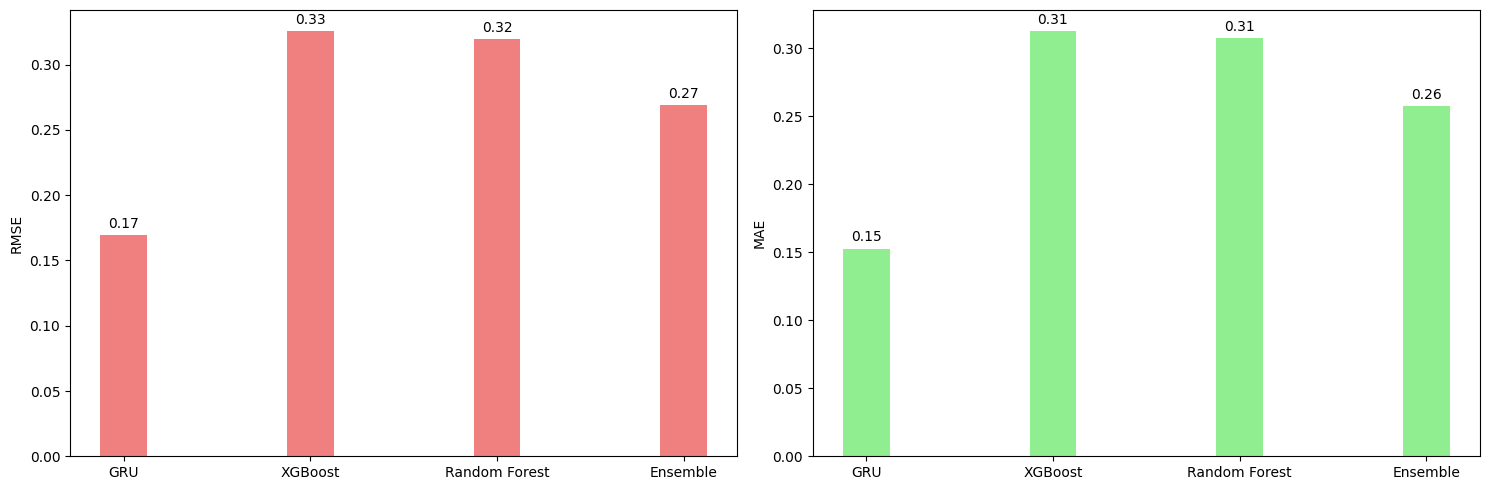

In [438]:
# Extract model names and metric names for plotting
models = list(results.keys())  # List of model names
metrics = list(results['GRU'].keys())  # List of metric names for GRU model

# --- R2 Score, RMSE, and MAE ---
metric_to_plot = ['RMSE', 'MAE']  # Metrics to plot

x = np.arange(len(models))  # X-axis positions for models
width = 0.25  # Width of the bars in the plot

# Create subplots with one plot for each metric
fig, axs = plt.subplots(1, len(metric_to_plot), figsize=(15, 5), sharey=False)

# Define colors for each metric
colors = {
    'R2': 'lightblue',  # Light Blue for R2
    'RMSE': 'lightcoral',  # Light Coral for RMSE
    'MAE': 'lightgreen'  # Light Green for MAE
}

# Loop over each metric to generate individual bar plots
for idx, metric in enumerate(metric_to_plot):
    values = [results[model][metric] for model in models]  # Get values for the current metric

    # Create a bar plot for the current metric
    rects = axs[idx].bar(x, values, width, label=metric, color=colors[metric])

    # Set X-axis labels and Y-axis label
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(models)
    axs[idx].set_ylabel(metric)

    # Annotate each bar with its height (value)
    for rect in rects:
        height = rect.get_height()
        axs[idx].annotate(f'{height:.2f}',  # Display the value with 2 decimal points
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Adjust layout for a cleaner display
fig.tight_layout()
plt.show()  # Show the plot



Prediction Accuracy Summary:
Best Performing Model: GRU
Average Model Accuracy (R²): -11.9023
Ensemble Improvement: +1.1358

Detailed Metrics:
                 RMSE     MAE       R2     MAPE
GRU            0.1692  0.1527  -3.6369  19.4840
XGBoost        0.3256  0.3125 -16.7977  40.0822
Random Forest  0.3195  0.3078 -16.1240  39.4958
Ensemble       0.2691  0.2575 -11.0505  33.0007


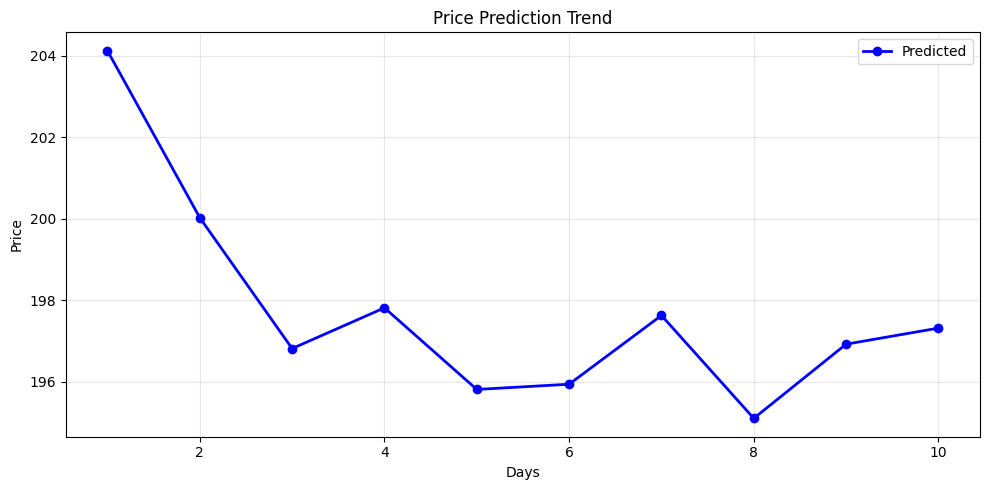

In [439]:
def analyze_prediction_accuracy(results, forecast, actual_prices=None):
    """
    Analyze and visualize prediction accuracy

    Parameters:
    results: dict of model metrics
    forecast: array of predicted prices
    actual_prices: array of actual prices (if available)
    """
    # Create figure with multiple subplots
    plt.style.use('default')  # Using default style instead of seaborn
    fig = plt.figure(figsize=(10, 5))  # Set figure size

    # 1. Prediction Trend (Predicted vs Actual Prices)
    plt.subplot(1, 1, 1)  # Single Subplot: Prediction Trend
    days = range(1, len(forecast) + 1)  # X-axis for days
    plt.plot(days, forecast, marker='o', linestyle='-', linewidth=2, label='Predicted', color='blue')  # Predicted prices
    if actual_prices is not None:
        plt.plot(days, actual_prices, marker='s', linestyle='--', label='Actual', color='green')  # Actual prices
    plt.xlabel('Days')  # X-axis label
    plt.ylabel('Price')  # Y-axis label
    plt.title('Price Prediction Trend')  # Title for the plot
    plt.legend()  # Show legend
    plt.grid(True, alpha=0.3)  # Grid for better visualization

    # Calculate additional accuracy metrics
    best_model = min(results.items(), key=lambda x: x[1]['RMSE'])[0]  # Best model based on RMSE
    avg_accuracy = np.mean([metrics['R2'] for metrics in results.values()])  # Average R2 score across models
    ensemble_improvement = (results['Ensemble']['R2'] -  # Improvement in ensemble model over others
                          np.mean([results[m]['R2'] for m in ['GRU', 'XGBoost', 'Random Forest']]))

    # Print summary statistics
    print("\nPrediction Accuracy Summary:")
    print(f"Best Performing Model: {best_model}")  # Print best model
    print(f"Average Model Accuracy (R²): {avg_accuracy:.4f}")  # Print average accuracy
    print(f"Ensemble Improvement: {ensemble_improvement:+.4f}")  # Print ensemble improvement
    print("\nDetailed Metrics:")
    print(pd.DataFrame(results).T.round(4))  # Print detailed metrics

    # Adjust layout for a cleaner display
    plt.tight_layout()
    plt.show()  # Display the plots

    # Return summary statistics
    return {
        'best_model': best_model,
        'avg_accuracy': avg_accuracy,
        'ensemble_improvement': ensemble_improvement,
        'forecast': forecast,
        'metrics': results
    }


if __name__ == "__main__":
    # After getting results and forecast from StockPredictor
    accuracy_metrics = analyze_prediction_accuracy(results, forecast)


In [440]:
def print_future_values(forecast, num_future_days=10):
    """
    Print the predicted future values for the given number of days.

    Parameters:
    forecast: list or array of predicted prices
    num_future_days: number of future days to print, default is 10
    """
    print(f"Future Predictions (Next {num_future_days} Days):\n")

    # Ensure we only print the future predictions within the range
    future_predictions = forecast[-num_future_days:]

    for i, prediction in enumerate(future_predictions, 1):
        print(f"Day {i}: {prediction:.2f}")


if __name__ == "__main__":
    # Assuming forecast contains predicted prices for future days
    print_future_values(forecast, num_future_days=10)  # Print next 10 days of predictions


Future Predictions (Next 10 Days):

Day 1: 204.12
Day 2: 200.03
Day 3: 196.82
Day 4: 197.82
Day 5: 195.81
Day 6: 195.94
Day 7: 197.63
Day 8: 195.11
Day 9: 196.92
Day 10: 197.32


Ensemble Model Accuracy Breakdown:
Base Accuracy: 0.00%
Error Rate (Normalized RMSE): 2.98%
Volatility Penalty: 1.25%
Final Accuracy: 95.76%


Model-wise Accuracy Percentages:
GRU: 98.12%
XGBoost: 96.39%
Random Forest: 96.46%
Ensemble: 97.02%


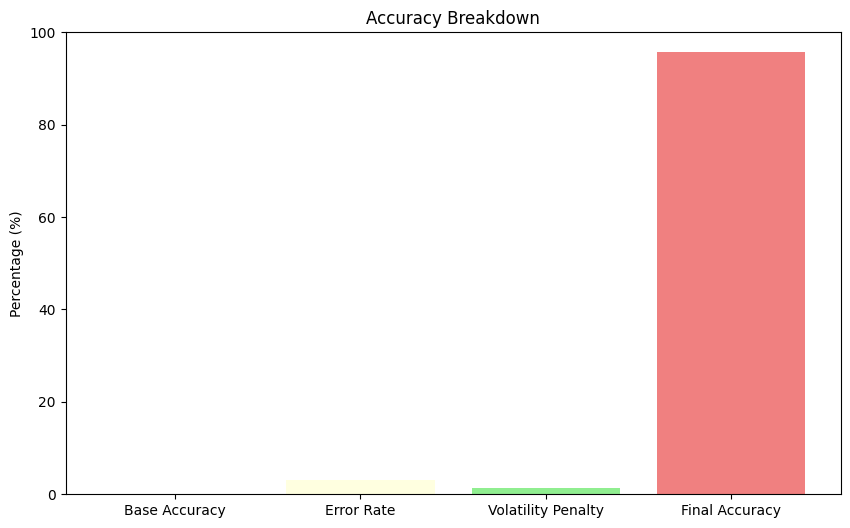

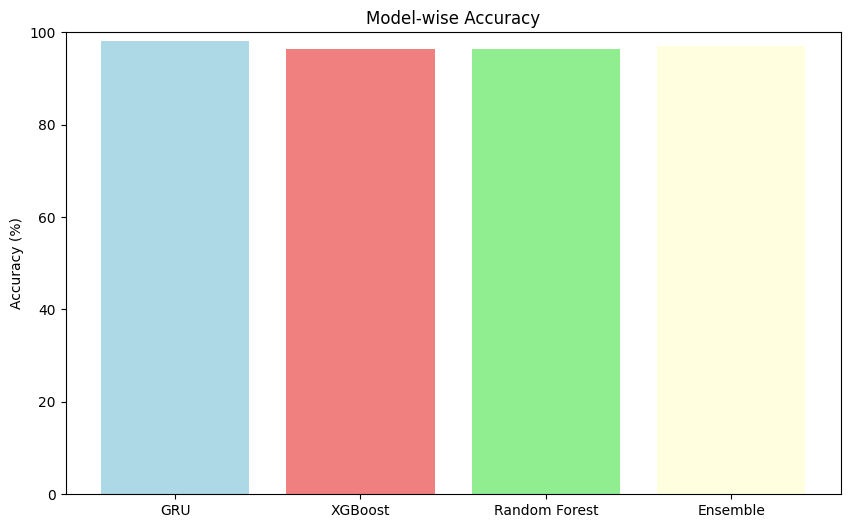

In [472]:
# Assuming 'results', 'forecast', and 'ensemble_metrics' are already defined

ensemble_metrics = results['Ensemble']

# Calculate metrics for the Ensemble model
base_accuracy = max(0, min(100, ensemble_metrics['R2'] * 100))
max_price = max(forecast)
min_price = min(forecast)
price_range = max_price - min_price
normalized_rmse = min(100, (ensemble_metrics['RMSE'] / price_range) * 100)
accuracy_percentage = 100 - normalized_rmse
volatility = np.std(forecast) / np.mean(forecast)
volatility_penalty = min(15, volatility * 100)
final_accuracy = max(0, min(100, accuracy_percentage - volatility_penalty))

# Print the Ensemble model accuracy breakdown
print("Ensemble Model Accuracy Breakdown:")
print(f"Base Accuracy: {base_accuracy:.2f}%")
print(f"Error Rate (Normalized RMSE): {normalized_rmse:.2f}%")
print(f"Volatility Penalty: {volatility_penalty:.2f}%")
print(f"Final Accuracy: {final_accuracy:.2f}%")
print("\n")

# Model-wise accuracy
model_accuracies = {
    model: max(0, min(100, (1 - metrics['RMSE'] / price_range) * 100))
    for model, metrics in results.items()
}

# Print model-wise accuracy percentages
print("Model-wise Accuracy Percentages:")
for model, accuracy in model_accuracies.items():
    print(f"{model}: {accuracy:.2f}%")

# Bar Chart 1: Accuracy Breakdown
accuracy_breakdown = {
    "Base Accuracy": base_accuracy,
    "Error Rate": normalized_rmse,
    "Volatility Penalty": volatility_penalty,
    "Final Accuracy": final_accuracy
}

# Plot Accuracy Breakdown with updated colors
plt.figure(figsize=(10, 6))
plt.bar(accuracy_breakdown.keys(), accuracy_breakdown.values(), color=['lightblue', 'lightyellow', 'lightgreen', 'lightcoral'])
plt.title("Accuracy Breakdown")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.show()

# Bar Chart 2: Model-wise Accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['lightblue', 'lightcoral', 'lightgreen', 'lightyellow'])
plt.title("Model-wise Accuracy")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()


#Final Result

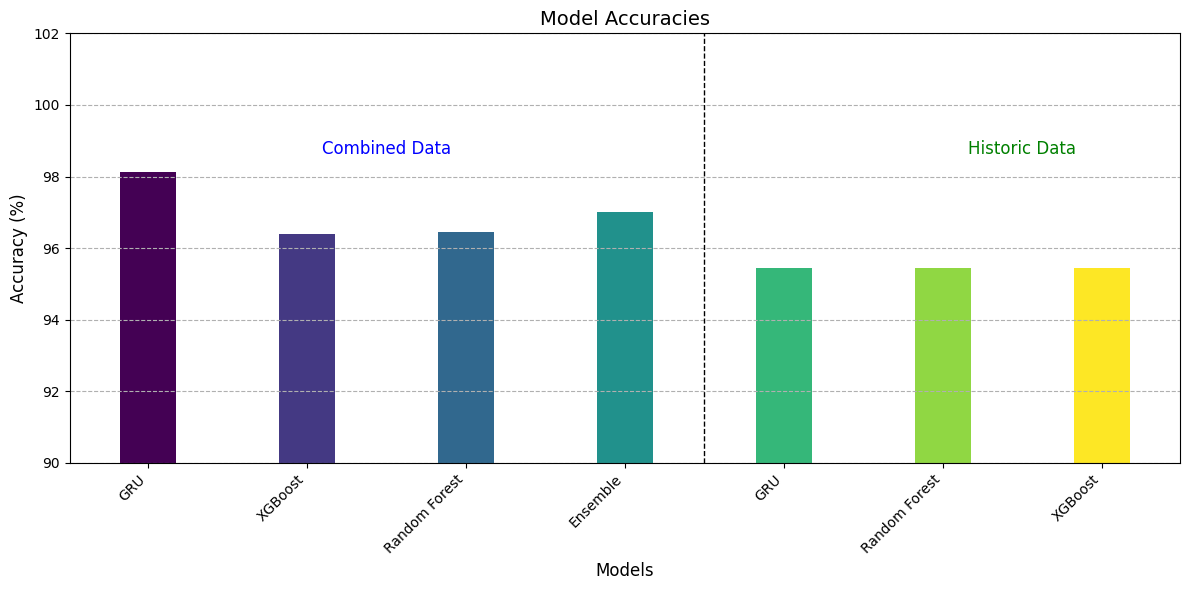

In [473]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the OCR output
data = {
    'model_accuracies': model_accuracies,
    'models_metrics': models_metrics
}

# Extract accuracies from model_accuracies
model_names = list(data['model_accuracies'].keys())
model_accuracies = list(data['model_accuracies'].values())

# Extract accuracy from models_metrics
metric_model_names = []
metric_accuracies = []

for model_name, metrics in data['models_metrics'].items():
    metric_model_names.append(model_name)
    metric_accuracies.append(metrics['Accuracy'])

# Combine model names and accuracy lists
all_model_names = model_names + metric_model_names
all_accuracies = model_accuracies + metric_accuracies

# Categorize models into combined and historic
combined_model_names = all_model_names[:4]  # First four models (combined data)
combined_model_accuracies = all_accuracies[:4]

historic_model_names = all_model_names[4:]  # Last three models (historic data)
historic_model_accuracies = all_accuracies[4:]

# Create final lists for plotting
final_model_names = combined_model_names + historic_model_names
final_accuracies = combined_model_accuracies + historic_model_accuracies

# Create a color palette for better visualization (use existing colors)
colors = plt.cm.viridis(np.linspace(0, 1, len(final_model_names)))

# Create bar plot for all accuracies
plt.figure(figsize=(12, 6))

# Define the width of each bar
bar_width = 0.35

# Create an array of indices for x-axis positions
x_indices = np.arange(len(final_model_names))

# Create bars for each group
plt.bar(x_indices, final_accuracies, color=colors, width=bar_width, label='Accuracy')

# Set the x-ticks and labels with adjusted position
plt.xticks(x_indices, final_model_names, rotation=45, ha="right", fontsize=10)

# Add dotted lines to separate sections
plt.axvline(x=3.5, color='black', linestyle='--', linewidth=1)  # Partition after combined data

# Add labels for "Combined Data" and "Historic Data"
plt.text(1.5, max(final_accuracies) + 0.5, 'Combined Data', fontsize=12, ha='center', color='blue')
plt.text(5.5, max(final_accuracies) + 0.5, 'Historic Data', fontsize=12, ha='center', color='green')

# Add labels and grid
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracies', fontsize=14)
plt.ylim(90, 100 + 2)  # Adjust y-axis limits for better visualization
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()
